In [117]:
import os
import sys 
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import plotly
import plotly.graph_objects as go
import plotly.express as px
import kaleido ##pip install -U kaleido ##to save a plotly fig
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score,cross_val_predict

In [118]:
df1 = pd.read_csv('Stable_Data_CSV.csv')
df2 = pd.read_csv('6wUsingBL.csv')
df_stable = df2[df2.set_index(['participant_id']).index.isin(df1.set_index(['participant_id']).index)]

In [122]:
df_stable_US = df_stable.loc[(df_stable['arm'] == 1)]
df_stable_WN = df_stable.loc[(df_stable['arm'] == 2)]
print(len(df_stable_US))
print(len(df_stable_WN))
df_stable_US=(df_stable_US[['c_3','sl_1','a_2','q_1','tfi_total.1','tfi_total.2','tfi_total.3']])
df_stable_WN=(df_stable_WN[['sl_2','r_1','e_1','tfi_total.1','tfi_total.2','tfi_total.3']])

31
30


In [216]:
# with scaled data
n_epochs=100
n_batch_size=32 #batch training
n_timesteps=1
lr=0.01
kfold = KFold(n_splits=5)
error_scores_US=[]
error_scores_WN=[]

def data_prep(df):
    sc_x=StandardScaler()
    sc_y=StandardScaler()
    ## Separate dependent and independent features 
    X=df.drop(['tfi_total.2','tfi_total.3'],axis=1).values
    y = df[['tfi_total.2']].values
    #scale x
    x_scaler=sc_x.fit(X)
    X=x_scaler.transform(X)
    #scale y
    y_scaler=sc_y.fit(y)
    y=y_scaler.transform(y)
    # Reshape input to be 3D for LSTM[samples, timesteps, features]
    X = X.reshape((X.shape[0],n_timesteps,X.shape[1]))
    print(X.shape,y.shape)
    input_shape=(n_timesteps,X.shape[2])
    print(input_shape)
    return X,y,input_shape,x_scaler,y_scaler

def create_lstm_model(input_shape,y_scaler):
    
    def error_in_tfi(y_true,y_pred): 
        y=y_true.numpy()
        yhat=y_pred.numpy()
        y=np.reshape(y, (1,-1))
        yhat=np.reshape(yhat, (1,-1))
        y=y_scaler.inverse_transform(y)
        yhat=y_scaler.inverse_transform(yhat)
        y=tf.convert_to_tensor(y, dtype=tf.float32)
        yhat=tf.convert_to_tensor(yhat, dtype=tf.float32)
        return K.mean(abs(y - yhat), axis=-1)  #K.mean(square(y_true - y_pred), axis=-1)
    
    K.clear_session
    input_shape=input_shape
    model = Sequential([
      LSTM(50, activation='relu',kernel_initializer='normal',input_shape=input_shape),
      Dropout(0.2), # 20% of Neuron will get deactivated during training
      Dense(1,kernel_initializer='normal',activation = 'linear')                      
    ])             

    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr),run_eagerly=True,metrics=[error_in_tfi])
    return model
    
def cross_val(df,error_scores):
    X,y,input_shape,x_scaler,y_scaler=data_prep(df)
    for train_index, test_index in kfold.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model=create_lstm_model(input_shape,y_scaler)
        history=model.fit(x_train, y_train,epochs=n_epochs,batch_size=n_batch_size,verbose =1)#validation_data=(x_test,y_test) #validation_split=0.2
        val_mse,val_mae=model.evaluate(x_test,y_test) #evaluating using unseen data, bcz validation is not used while model.fit
        error_scores.append(val_mae)
    return history,x_scaler,y_scaler,error_scores

US_history,US_x_scaler,US_y_scaler,US_error_scores=cross_val(df_stable_US,error_scores_US)
WN_history,WN_x_scaler,WN_y_scaler,WN_error_scores=cross_val(df_stable_WN,error_scores_WN)
    

(31, 1, 5) (31, 1)
(1, 5)
TRAIN: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30] TEST: [0 1 2 3 4 5 6]
Epoch 1/100
1/1 [==============================] - 0s 35ms/step - loss: 0.9099 - error_in_tfi: 16.1004
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 0.9015 - error_in_tfi: 16.0215
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.8910 - error_in_tfi: 15.9275
Epoch 4/100
1/1 [==============================] - 0s 29ms/step - loss: 0.8845 - error_in_tfi: 15.8625
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 0.8761 - error_in_tfi: 15.7511
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.8589 - error_in_tfi: 15.5717
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 0.8479 - error_in_tfi: 15.4334
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.8409 - error_in_tfi: 15.2924
Epoch 9/100
1/1 [==============================

1/1 [==============================] - 0s 26ms/step - loss: 0.3164 - error_in_tfi: 8.5032
Epoch 53/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2421 - error_in_tfi: 7.8346
Epoch 54/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3078 - error_in_tfi: 8.2945
Epoch 55/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2343 - error_in_tfi: 7.3628
Epoch 56/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2042 - error_in_tfi: 6.5137
Epoch 57/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1886 - error_in_tfi: 6.3066
Epoch 58/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2322 - error_in_tfi: 7.0918
Epoch 59/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2695 - error_in_tfi: 7.8376
Epoch 60/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1745 - error_in_tfi: 6.1332
Epoch 61/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2266 - erro

Epoch 28/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3459 - error_in_tfi: 8.9879
Epoch 29/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3207 - error_in_tfi: 8.4817
Epoch 30/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3572 - error_in_tfi: 9.2053
Epoch 31/100
1/1 [==============================] - 0s 26ms/step - loss: 0.3565 - error_in_tfi: 8.9008
Epoch 32/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3480 - error_in_tfi: 9.1478
Epoch 33/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3435 - error_in_tfi: 8.7601
Epoch 34/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2848 - error_in_tfi: 7.7297
Epoch 35/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2977 - error_in_tfi: 8.1977
Epoch 36/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2836 - error_in_tfi: 7.6843
Epoch 37/100
1/1 [==============================] - 0s 26ms/step - loss: 

Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0637 - error_in_tfi: 16.8948
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 1.0506 - error_in_tfi: 16.8417
Epoch 6/100
1/1 [==============================] - 0s 26ms/step - loss: 1.0264 - error_in_tfi: 16.6380
Epoch 7/100
1/1 [==============================] - 0s 26ms/step - loss: 1.0083 - error_in_tfi: 16.5145
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.9653 - error_in_tfi: 16.1287
Epoch 9/100
1/1 [==============================] - 0s 26ms/step - loss: 0.9412 - error_in_tfi: 15.9627
Epoch 10/100
1/1 [==============================] - 0s 27ms/step - loss: 0.9136 - error_in_tfi: 15.7131
Epoch 11/100
1/1 [==============================] - 0s 27ms/step - loss: 0.8844 - error_in_tfi: 15.4595
Epoch 12/100
1/1 [==============================] - 0s 28ms/step - loss: 0.8476 - error_in_tfi: 15.0005
Epoch 13/100
1/1 [==============================] - 0s 27ms/step - los

1/1 [==============================] - 0s 28ms/step - loss: 0.2259 - error_in_tfi: 7.1945
Epoch 59/100
1/1 [==============================] - 0s 28ms/step - loss: 0.3083 - error_in_tfi: 8.5993
Epoch 60/100
1/1 [==============================] - 0s 27ms/step - loss: 0.3575 - error_in_tfi: 9.0864
Epoch 61/100
1/1 [==============================] - 0s 30ms/step - loss: 0.2143 - error_in_tfi: 7.1305
Epoch 62/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2089 - error_in_tfi: 6.9591
Epoch 63/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1887 - error_in_tfi: 6.7135
Epoch 64/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2345 - error_in_tfi: 7.5125
Epoch 65/100
1/1 [==============================] - 0s 28ms/step - loss: 0.1682 - error_in_tfi: 6.1336
Epoch 66/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1581 - error_in_tfi: 6.1766
Epoch 67/100
1/1 [==============================] - 0s 26ms/step - loss: 0.1582 - erro

1/1 [==============================] - 0s 26ms/step - loss: 0.9071 - error_in_tfi: 17.2011
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.8705 - error_in_tfi: 16.8155
Epoch 11/100
1/1 [==============================] - 0s 26ms/step - loss: 0.8426 - error_in_tfi: 16.5144
Epoch 12/100
1/1 [==============================] - 0s 25ms/step - loss: 0.7890 - error_in_tfi: 15.8641
Epoch 13/100
1/1 [==============================] - 0s 26ms/step - loss: 0.7587 - error_in_tfi: 15.3348
Epoch 14/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6997 - error_in_tfi: 14.1092
Epoch 15/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6689 - error_in_tfi: 13.5226
Epoch 16/100
1/1 [==============================] - 0s 26ms/step - loss: 0.6445 - error_in_tfi: 12.9450
Epoch 17/100
1/1 [==============================] - 0s 25ms/step - loss: 0.5965 - error_in_tfi: 11.9973
Epoch 18/100
1/1 [==============================] - 0s 26ms/step - loss: 0.60

1/1 [==============================] - 0s 27ms/step - loss: 0.2222 - error_in_tfi: 7.6215
Epoch 64/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2251 - error_in_tfi: 7.6315
Epoch 65/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2869 - error_in_tfi: 8.7710
Epoch 66/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2375 - error_in_tfi: 7.8306
Epoch 67/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2513 - error_in_tfi: 8.2201
Epoch 68/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2376 - error_in_tfi: 7.7207
Epoch 69/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2293 - error_in_tfi: 7.4858
Epoch 70/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2592 - error_in_tfi: 7.9511
Epoch 71/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2212 - error_in_tfi: 7.1895
Epoch 72/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2299 - erro

1/1 [==============================] - 0s 30ms/step - loss: 0.2841 - error_in_tfi: 8.2997
Epoch 40/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2680 - error_in_tfi: 7.8147
Epoch 41/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2913 - error_in_tfi: 8.4273
Epoch 42/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2652 - error_in_tfi: 8.2356
Epoch 43/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2762 - error_in_tfi: 7.9282
Epoch 44/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2313 - error_in_tfi: 7.3989
Epoch 45/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2255 - error_in_tfi: 7.6577
Epoch 46/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2497 - error_in_tfi: 7.8083
Epoch 47/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2585 - error_in_tfi: 7.9982
Epoch 48/100
1/1 [==============================] - 0s 26ms/step - loss: 0.2353 - erro

1/1 [==============================] - 0s 26ms/step - loss: 0.7492 - error_in_tfi: 14.8916
Epoch 16/100
1/1 [==============================] - 0s 26ms/step - loss: 0.7576 - error_in_tfi: 15.0853
Epoch 17/100
1/1 [==============================] - 0s 25ms/step - loss: 0.7411 - error_in_tfi: 14.7707
Epoch 18/100
1/1 [==============================] - 0s 25ms/step - loss: 0.7209 - error_in_tfi: 14.3147
Epoch 19/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6615 - error_in_tfi: 13.3143
Epoch 20/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6835 - error_in_tfi: 13.6221
Epoch 21/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6297 - error_in_tfi: 13.0445
Epoch 22/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6215 - error_in_tfi: 12.9466
Epoch 23/100
1/1 [==============================] - 0s 25ms/step - loss: 0.6594 - error_in_tfi: 13.5250
Epoch 24/100
1/1 [==============================] - 0s 26ms/step - loss: 0.65

In [229]:
print(US_error_scores)
US_error=np.mean(US_error_scores)
print(US_error)
print(WN_error_scores)
WN_error=np.mean(WN_error_scores)
print(WN_error)

[13.839458465576172, 12.64130973815918, 17.01807975769043, 16.65719223022461, 15.335909843444824]
15.098390007019043
[14.72717571258545, 18.423831939697266, 14.28192138671875, 27.302902221679688, 25.29901123046875]
20.00696849822998


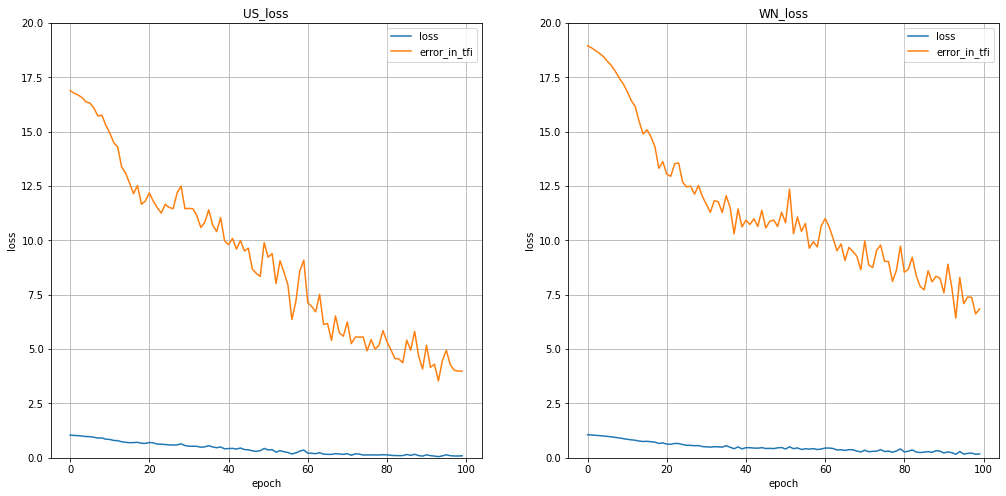

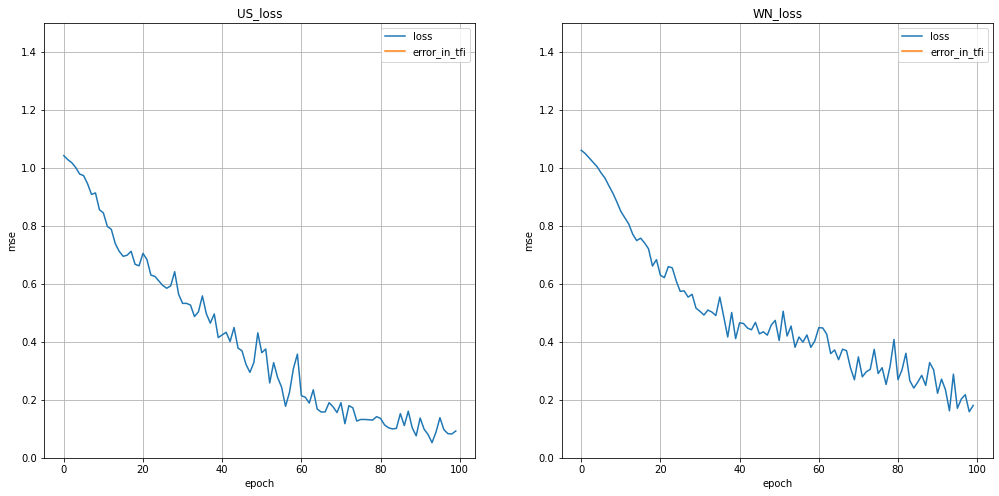

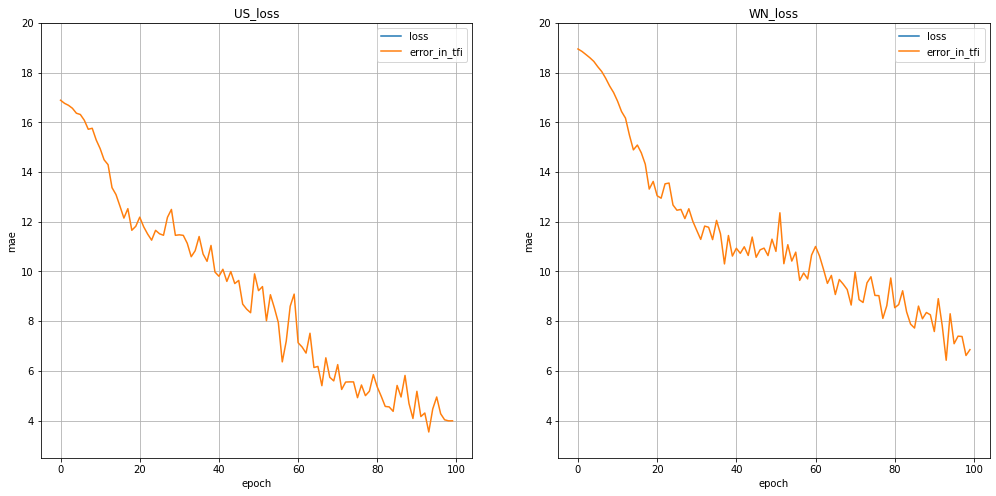

In [223]:
#show learning curves
#mean training loss measured over each epoch
#mean validation loss measured at the end of each epoch
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,20),title="US_loss",xlabel='epoch',ylabel='loss').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,20),title="WN_loss",xlabel='epoch',ylabel='loss').grid(True)
plt.savefig("plots/loss_and_matrics.png")

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(0,1.5),title="US_loss",xlabel='epoch',ylabel='mse').grid(True)
WN_plot.plot(ax=axes[1],ylim=(0,1.5),title="WN_loss",xlabel='epoch',ylabel='mse').grid(True)
plt.savefig("plots/loss.png")

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(17,8))
US_plot = pd.DataFrame(US_history.history) #selecting columns
WN_plot = pd.DataFrame(WN_history.history)
US_plot.plot(ax=axes[0],ylim=(2.5,20),title="US_loss",xlabel='epoch',ylabel='mae').grid(True)
WN_plot.plot(ax=axes[1],ylim=(2.5,20),title="WN_loss",xlabel='epoch',ylabel='mae').grid(True)
plt.savefig("plots/matrics.png")

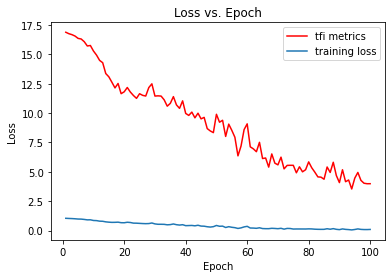

In [241]:
def plot_loss(history):
        train_loss=history.history['loss']
        train_metrics=history.history['error_in_tfi']
        x=list(range(1,len(train_metrics)+1))
        plt.plot(x,train_metrics,color='red',label='tfi metrics')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(US_history)

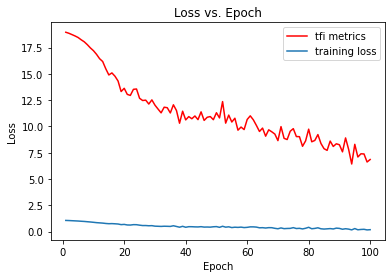

In [245]:
def plot_loss(history):
        train_loss=history.history['loss']
        train_metrics=history.history['error_in_tfi']
        x=list(range(1,len(train_metrics)+1))
        plt.plot(x,train_metrics,color='red',label='tfi metrics')
        plt.plot(x,train_loss,label='training loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()

plot_loss(WN_history)